# Homework 3 (Tutorial 7)

##MA course in Artificial Intelligence 2022/2023

@author: Filippo Casari

In [2]:
#!rm -r AI2022MA/
#!git clone https://github.com/UmbertoJr/AI2022MA.git &> /dev/null

name: eil76
nPoints: 76
best_sol: 538.0


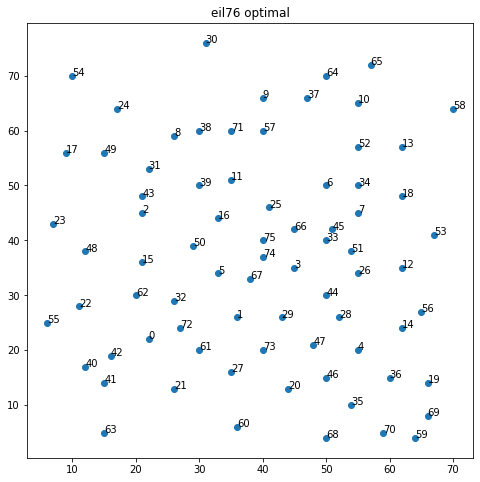

In [3]:
# Imports

#from AI2022MA.IO_manager.io_tsp import TSP_Instance_Creator
# if you are running from your local remove the prefix AI2020 (comment the previous line and uncomment the following line)
from IO_manager.io_tsp import TSP_Instance_Creator

ic = TSP_Instance_Creator("standard", 'eil76.tsp')
ic.print_info()
ic.plot_data()

name: ch130
nPoints: 130
best_sol: 6110.0


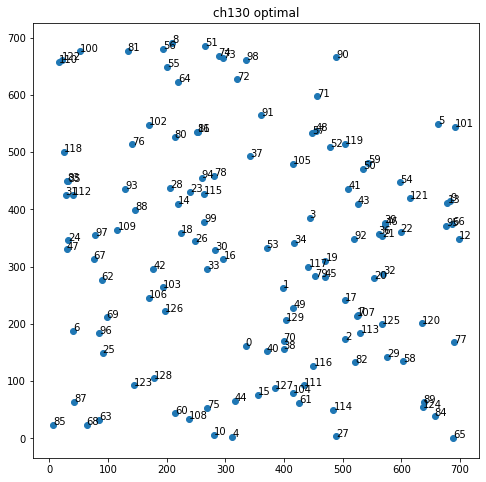

In [4]:
ic = TSP_Instance_Creator("standard", 'ch130.tsp')
ic.print_info()
ic.plot_data()

name: d198
nPoints: 198
best_sol: 15780.0


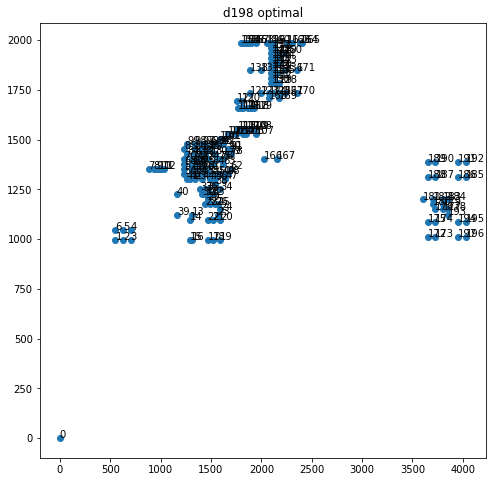

In [5]:
ic = TSP_Instance_Creator("standard", 'd198.tsp')
ic.print_info()
ic.plot_data()

name: myTSP_dim10
nPoints: 10
best_sol: 2732.0


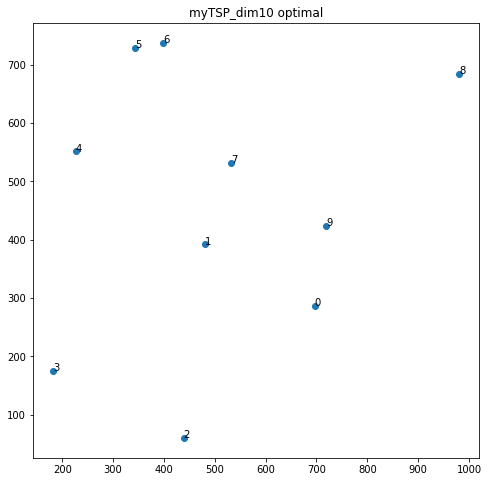

In [6]:
ic = TSP_Instance_Creator("standard", 'myTSP_dim10.tsp')
ic.print_info()
ic.plot_data()

In [7]:
from matplotlib import pyplot as plt
%matplotlib notebook
plt.ion()


def plot_tour(instance, tour, ant):

    plt.figure(figsize=(8, 8))
    plt.grid()
    plt.title(f"Tour Ant # {ant}")
    plt.scatter(instance.points[:, 1], instance.points[:, 2])
    for t in range(len(tour)-1):
        xy1, xy2 = tour[t], tour[t+1]
        plt.plot([instance.points[xy1, 1], instance.points[xy2, 1]], [
                 instance.points[xy1, 2], instance.points[xy2, 2]], color="blue")

        plt.draw()
        plt.pause(0.2)
    # plt.show()


In [12]:
import numpy as np
import random
from solvers.local_search import twoOpt
from solvers.constructive_algorithms import nn
from solvers.two_opt_with_candidate import twoOpt_with_cl
# nn takes as input the distance matrix and returns
# the tour and the length constructed with nearest neighbor, i.e.   tour, len_t = nn(dist_mat)

# twoOpt takes as input the solution, the actual_len and the distance matrix
# and returns the tour and the length created with 2-opt, i.e.     tour, lent_t = twoOpt(solution, actual_len, dist_mat)
pheromon_global = 0.


class ACS:
    m = 10
    beta = 2
    alpha = rho = 0.1
    cl = 20
    q0 = 0.98

    @staticmethod
    def take_candidates(j, dist_mat):
        # print(dist_mat[j][1:ACS.cl+1])

        # print(dist_mat[j][1:])
        # print(sorted(dist_mat[j])[1:ACS.cl+1])
        # print(list(np.argsort(dist_mat[j])[1:ACS.cl+1]))

        # da 1 citta vicina a 21 citta', sorting delle citta vicine
        return (np.argsort(dist_mat[j])[1:ACS.cl+1])

    @staticmethod
    def take_other_cities(j, dist_mat):
        return (np.argsort(dist_mat[j])[ACS.cl+1:])

    def __init__(self, instance):
        """constructor

        Args:
            instance (instance of TSP_Creator): problem to solve
        """
        self.instance = instance
        self.n = instance.nPoints
        self.dist_mat = instance.dist_matrix
        _, self.L_nn = nn(instance.dist_matrix,
                          starting_node=np.random.choice(self.n))
        self.tau0 = 1./(float(self.n) * self.L_nn)
        print("tau0: ", self.tau0)
        # position collector for the Ants, TO BE UPDATED during the steps
        self.position = {i: None for i in range(ACS.m)}
        self.tour = {i: []
                     for i in range(ACS.m)}  # tour collector for the Ants
        #self.pheromone = {r: [self.tau0]*ACS.cl for r in range(self.n)}
        self.pheromone = {r: [self.tau0]*(self.n) for r in range(self.n)}
        self.candidate_list = {r: ACS.take_candidates(r, instance.dist_matrix) for r in range(
            self.n)}  # per tutte le citta', prende le citta vicine
        #self.eta = {r: [1/self.dist_mat[r, s] for s in ACS.take_candidates(r, instance.dist_matrix)] for r in range(self.n)}
        self.eta = {r: [1./(self.dist_mat[r, s]+np.finfo(np.double).eps)
                        for s in range(self.n)] for r in range(self.n)}
        self.tour_len = {i: 0. for i in range(ACS.m)}
        self.best_tour = []
        self.best_ant = 0
        self.best_tour_len = 10e8
        self.iterations = 10

    def global_update(self):
        """Global pheromone updating
        """
        for k1, val1 in self.pheromone.items():

            for k2, val2 in self.pheromone.items():
                #print(self.pheromone[k1][k2], "pheromone before")
                if(k1 == k2):
                    self.pheromone[k1][k2] = 0.
                else:
                    delta_tau = 0.
                    if(k1 in self.best_tour and k2 in self.best_tour):
                        delta_tau = 1./self.best_tour_len

                    self.pheromone[k1][k2] = (
                        1. - self.alpha) * self.pheromone[k1][k2] + (self.alpha * delta_tau)
                    self.pheromone[k2][k1] = (
                        1. - self.alpha) * self.pheromone[k2][k1] + (self.alpha * delta_tau)
                    #print(self.pheromone[k1][k2], "pheromone after")

    def solve(self):
        """Solving ACS
        """
        for iteration in range(self.iterations):
            if(iteration % 5 == 0):
                print("iteration : ", iteration)
            self.loop()
            best_tour_ant = min(self.tour_len, key=self.tour_len.get)
            best_len = min(self.tour_len.values())
            if(best_len < self.best_tour_len):
                self.best_tour_len = best_len
                self.best_ant = best_tour_ant
                self.best_tour = self.tour[best_tour_ant]

            print("best tour len this time: ",
                  best_len, "by ant # ", best_tour_ant)
            self.two_Opt_Improvement()
            self.global_update()
            self.tour = {i: []
                         for i in range(ACS.m)}
            self.position = {i: None for i in range(self.m)}
            self.tour_len = {i: 0. for i in range(self.m)}

    def local_update(self, k):
        """local pheromone update

        Args:
            k (int): ant number
        """
        # print(self.tour)
        old_city = self.tour[k][-2]
        next_city = self.position[k]
        old_ph = self.pheromone[old_city][next_city]
        pheromon = ((1.-self.rho) * old_ph) + (self.rho * self.tau0)
        self.pheromone[old_city][next_city] = pheromon
        self.pheromone[next_city][old_city] = pheromon
        self.tour_len[k] += self.dist_mat[old_city, next_city]

        '''if(k==0):
      
      print("old ph ", old_ph)
      print(f"pherormone edges{(old_city, next_city)}")
      print("new pheromone", pheromon)#self.pheromone[old_city][next_city]'''

    def loop(self, verbose=False):
        """each ant contructs its own tour

        Args:
            verbose (bool, optional): log or not. Defaults to False.
        """
        count_exploration = 0
        count_exploitation = 0
        for node_idx in range(self.n):
            # if(node_idx % 15 == 0):
            #    print(f"iteration #{node_idx}")
            if(node_idx < self.n-1):

                for k in range(self.m):
                    if(self.position[k] == None):
                        self.position[k] = np.random.randint(
                            low=0, high=self.n-1)
                        """if(k == 0 and verbose):
                            print(
                                f"ant {k} starting from position: {self.position[k]}")"""
                        self.tour[k].append(self.position[k])
                    q = np.random.random()

                    eta_beta = np.power(self.eta[self.position[k]], self.beta)

                    s_list = eta_beta*self.pheromone[self.position[k]]
                    s_dict = {}

                    for s, city in zip(s_list, self.candidate_list[self.position[k]]):
                        s_dict[city] = s

                    for city in self.tour[k]:
                        s_dict.pop(city, None)
                    if(not s_dict):
                        for s, city in zip(s_list, self.take_other_cities(self.position[k], self.dist_mat)):
                            if(city not in self.tour[k]):
                                s_dict[city] = s
                    # print(s_dict)

                    if(q < self.q0):

                        next_city = max(s_dict, key=s_dict.get)

                        self.position[k] = next_city
                        self.tour[k].append(next_city)
                        if(k == 0 and verbose):
                            count_exploitation += 1
                            # print("#exploitation: ", count_exploitation)

                    else:
                        somma_prob = sum(s_dict.values()) + \
                            np.finfo(np.float64).eps
                        for city, s in s_dict.items():
                            s_dict[city] = (s/somma_prob)
                            if(s_dict[city] == 0.):
                                s_dict[city] = np.finfo(np.float64).eps
                        somma_prob = sum(s_dict.values()) + \
                            np.finfo(np.float64).eps
                        for city, s in s_dict.items():
                            s_dict[city] = (s/somma_prob)
                        #print(f"sum probability= {sum(s_dict.values())}")

                        try:
                            next_city = random.choices(
                                list(s_dict.keys()), weights=(list(s_dict.values())), k=1)[0]
                        except:
                            print(s_dict.values())
                        #print("next city randly chosen:", next_city)
                        self.tour[k].append(next_city)
                        self.position[k] = next_city
                        if(k == 0):

                            count_exploration += 1

                    self.local_update(k)
            else:
                for k in range(self.m):
                    self.tour[k].append(self.tour[k][0])

            #print("position ant 0", self.position[0])

        print("path lengths", self.tour_len)
        '''
        if len(self.tour[k][:-1]) > len(set(self.tour[k][-1])):
            print("some repetitions")
      '''
        # if(k==0):
        #  plot_tour(self.instance, self.tour[k], k)

    def two_Opt_Improvement(self):
        best_tour, best_tour_len = twoOpt_with_cl(
            self.best_tour, self.best_tour_len, ic.dist_matrix, self.candidate_list)
        if(best_tour_len<self.best_tour_len):
            print(f"initial tour: {self.best_tour_len}. Improved by 2 opt: {best_tour_len}")
            self.best_tour, self.best_tour_len = best_tour, best_tour_len


In [13]:

seeds = [0, 40, 60]
instances = ["eil76.tsp", "ch130.tsp", "d198.tsp"]
for seed in seeds:
    random.seed(seed)
    np.random.seed(seed)
    print(f"-------  SEED = {seed} ---------")
    for instance in instances:
        print(f"-------  INSTANCE = {instance} ---------")
        ic = TSP_Instance_Creator("standard", instance)
        acs = ACS(ic)
        # print(acs.pheromone)
        # print(acs.candidate_list)
        acs.solve()
        print(
            f"absulute best lenght= {acs.best_tour_len}, by ant # {acs.best_ant}. Tour:\n {acs.best_tour}")

#print(f"difference len ACS - NN = {acs.best_tour_len - acs.L_nn}")


-------  SEED = 0 ---------
-------  INSTANCE = eil76.tsp ---------
tau0:  1.9756598703967125e-05
iteration :  0
path lengths {0: 1038.0, 1: 1079.0, 2: 1090.0, 3: 1037.0, 4: 1059.0, 5: 1130.0, 6: 1083.0, 7: 961.0, 8: 1174.0, 9: 1142.0}
best tour len this time:  961.0 by ant #  7
initial tour: 961.0. Improved by 2 opt: 610.0
path lengths {0: 1048.0, 1: 1091.0, 2: 1060.0, 3: 1163.0, 4: 1114.0, 5: 1158.0, 6: 1083.0, 7: 1124.0, 8: 1100.0, 9: 1099.0}
best tour len this time:  1048.0 by ant #  0
path lengths {0: 1144.0, 1: 1153.0, 2: 1071.0, 3: 1085.0, 4: 1088.0, 5: 1118.0, 6: 1087.0, 7: 1191.0, 8: 1154.0, 9: 1103.0}
best tour len this time:  1071.0 by ant #  2
path lengths {0: 1160.0, 1: 1086.0, 2: 1091.0, 3: 1134.0, 4: 1090.0, 5: 1097.0, 6: 1112.0, 7: 1095.0, 8: 1097.0, 9: 1087.0}
best tour len this time:  1086.0 by ant #  1
path lengths {0: 1080.0, 1: 1122.0, 2: 1089.0, 3: 1078.0, 4: 1095.0, 5: 1131.0, 6: 1114.0, 7: 1096.0, 8: 1157.0, 9: 1196.0}
best tour len this time:  1078.0 by ant #  

In [ ]:
%matplotlib
plot_tour(acs.instance, acs.best_tour,acs.best_ant )

Using matplotlib backend: MacOSX


KeyboardInterrupt: 

# test twoOpt_with_cl 

the implementation of 2opt with the candidate list has worst performances in term of quality but achieves improvements using fewer computation

In [ ]:
from time import time


ic = TSP_Instance_Creator("standard", 'fl1577.tsp')

initial_sol, initial_len = nn(ic.dist_matrix, starting_node=np.random.choice(ic.nPoints))
acs = ACS(ic)

tau0:  2.207615265995122e-08


In [ ]:
start = time()
tour, len_new = twoOpt_with_cl(initial_sol, initial_len, ic.dist_matrix, acs.candidate_list)
print(f' 2opt with candidate: initial len {initial_len}, final len {len_new} \n execution time: {time() - start}')

start = time()
tour, len_new = twoOpt(initial_sol, initial_len, ic.dist_matrix)
print(f' 2opt: initial len {initial_len}, final len {len_new} \n execution time: {time() - start}')

 2opt with candidate: initial len 28178.0, final len 28075.0 
 execution time: 2.3417179584503174
 2opt: initial len 28178.0, final len 23958.0 
 execution time: 97.69778490066528


In [ ]:


list_time = []
for _ in range(5):
  start = time()
  _ = twoOpt_with_cl(initial_sol, initial_len, ic.dist_matrix, acs.candidate_list)
  list_time.append(time()- start)

print(f"mean {np.mean(list_time)},  std {np.std(list_time)}" )

KeyboardInterrupt: 

In [ ]:

list_time = []
for _ in range(5):
  start = time()
  _ = twoOpt(initial_sol, initial_len, ic.dist_matrix)
  list_time.append(time() - start)

print(f"mean {np.mean(list_time)},  std {np.std(list_time)}" )